# Bifurcation Existence Verification for the Unreinforced Box Beam

## Problem definition <a name="problem"></a>

***

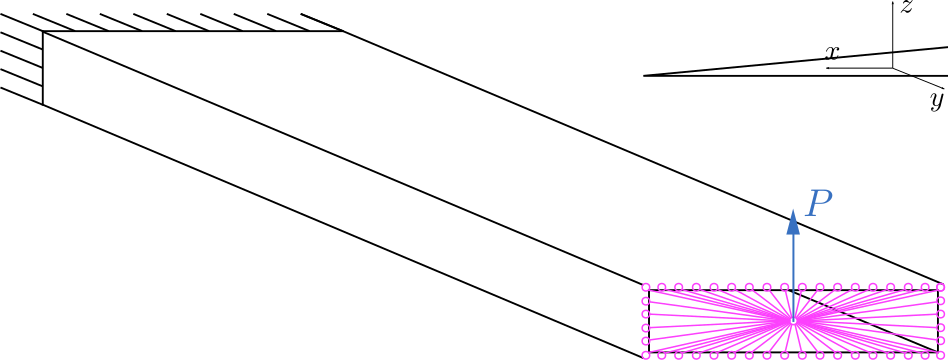

In [134]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [135]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [136]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

### Mesh and boundary conditions

In [137]:
from resources import box_beam_utils

edge_length = 86  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


### Load

In [138]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

## Nonlinear analysis parameters

***

In [139]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf_input)  # set up SOL 106 with arc-length method using default parameters

Run reference analysis.

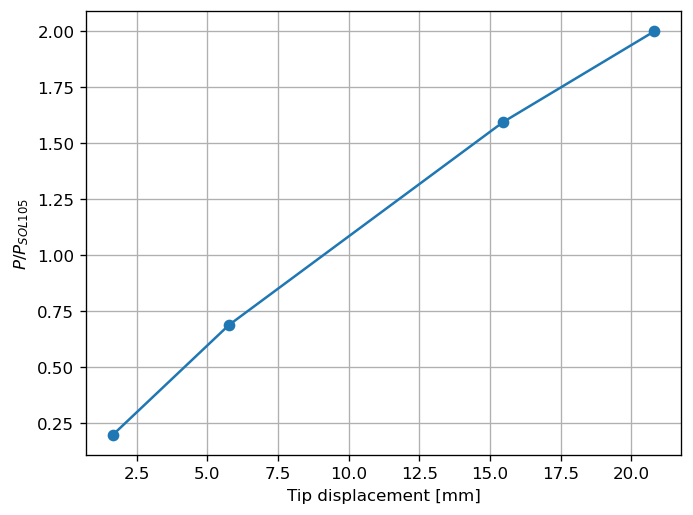

In [140]:
import matplotlib.pyplot as plt  # plotting package
from pyNastran.op2.op2 import read_op2  # function to read Nastran op2 files

# Create subcase where we apply the buckling load predicted by SOL 105
sol_105_buckling_load = 1657.  # [N]
load_set_id = force_set_id + 1  # define id of load set
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[2*sol_105_buckling_load], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

# Run analysis
analysis_directory_name = '13_Bifurcation_Existence_Verification_for_the_Unreinforced_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_filename = 'nonlinear_analysis_reference'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None, load_geometry=True)

# Find load and displacement history
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)

# Plot load-displacement diagram
plt.rcParams['figure.dpi'] = 120  # default dpi of figures
load_component_index = 2  # select load along z-axis
displacement_component_index = 2  # select displacement along z-axis
_, ax = plt.subplots()  # create figure with one subplot
ax.plot(tip_displacements[1][:,displacement_component_index], applied_loads[1][:, load_component_index]/sol_105_buckling_load, 'o-')  # plot load vs displacement
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()

Define plotting function.

In [141]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

markers = list(Line2D.markers.keys())[2:]  # list of marker characters

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=False)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], p[1][:, load_component_index]/sol_105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

Error function.

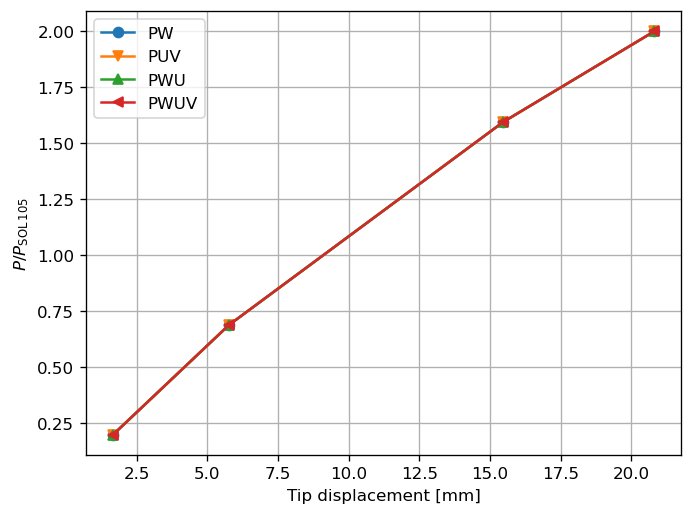

In [142]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

nlparm_id = next(iter(box_beam_bdf_input.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'{fun}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Restore default value.

In [143]:
box_beam_bdf_input.nlparms[nlparm_id].conv = 'PW'

Convergence tolerances.

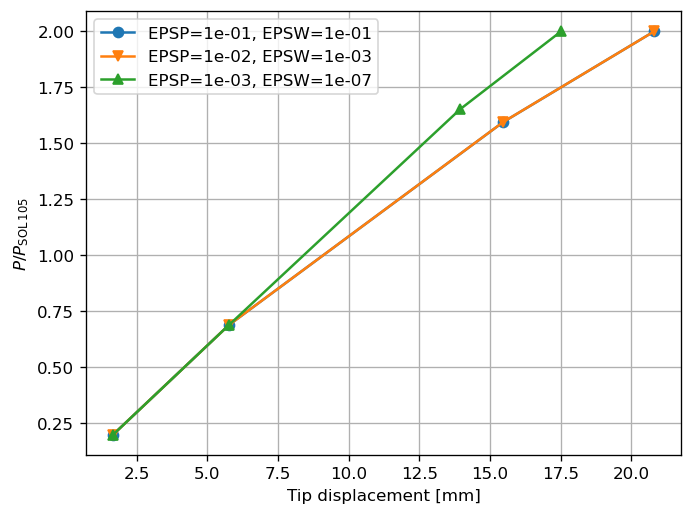

In [144]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')

# Set plot appearance
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

## Bifurcation existence verification

***

Define subcases to verify whether the difference in previous results is caused by a bifurcation.

1. Concentrated tip load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
2. No load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$
3. Concentrated tip load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.1, DESITER=12, MAXALR=4$
4. No load, $EPSP=10^{-1}, EPSW=10^{-1}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$

In [145]:
# Define load set with no applied force
zero_load_set_id = load_set_id+1
box_beam_bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])

LOAD          13      1.      0.      11

In [146]:
# Create second subcase
subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=subcase_id, load_set_id=zero_load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input, nlparm_id=subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100, desiter=5, minalr=1e-2, maxalr=1.01, maxinc=35, subcase_id=subcase_id)


# Create third subcase
subcase_id = 3
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=subcase_id, load_set_id=load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input, nlparm_id=subcase_id, eps_p=1e-1, eps_w=1e-1, subcase_id=subcase_id)

# Create fourth subcase
subcase_id = 4
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=subcase_id, load_set_id=zero_load_set_id)
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input, nlparm_id=subcase_id, eps_p=1e-1, eps_w=1e-1, ninc=100, desiter=5, minalr=1e-2, maxalr=1.01, maxinc=35, subcase_id=subcase_id)

Run analysis and calculate lowest eigenvalue of tangent stiffness matrix for each converged iteration.

In [147]:
input_filename = 'bifurcation_verification_2Psol105_epsp1e-3'
op2_output_2Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-3.bdf completed
Wall time: 39.0 s


Read load-displacement history from `OP2` object and plot load-displacement diagram for each subcase.

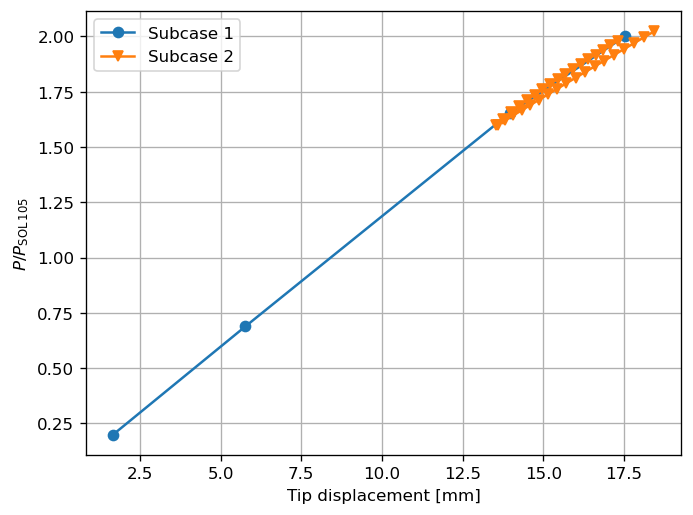

In [148]:
def plot_load_displacement_diagram(disp, loads):
    _, load_displacement_ax = plt.subplots()
    for subcase in loads:
        load_displacement_ax.plot(disp[subcase][:, displacement_component_index], loads[subcase][:, load_component_index]/sol_105_buckling_load, marker=markers[subcase - 1], label=f'Subcase {subcase:d}')
    load_displacement_ax.legend()
    plt.xlabel('Tip displacement [mm]')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

_, applied_loads_2Psol105_epsp1em3, tip_displacements_2Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_epsp1em3, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em3, applied_loads_2Psol105_epsp1em3)

Read eigenvalues of tangent stiffness matrix from f06 file and plot them against the iteration number and the applied load.

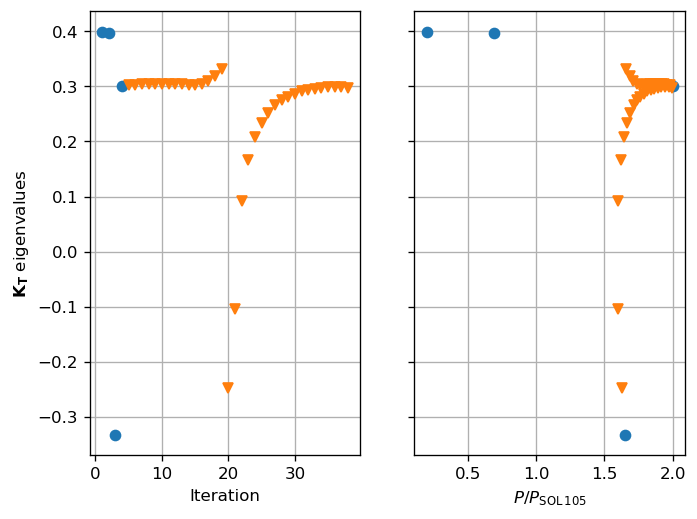

In [149]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1], label=f'Subcase {subcase:d}')
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], displacement_component_index]/sol_105_buckling_load, eigenvalues_by_subcase[subcase].T, markers[subcase - 1], color=colors[subcase - 1])
    # Set plot appearance
    # axs[0].legend()
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_2Psol105_epsp1em3)

Repeat calculating more than one eigenvalue.

In [150]:
no_eigenvalues = 9
input_filename = f'bifurcation_verification_2Psol105_epsp1e-3_{no_eigenvalues:d}eigenvalues'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=True)

Nastran job bifurcation_verification_2Psol105_epsp1e-3_9eigenvalues.bdf completed
Wall time: 48.0 s


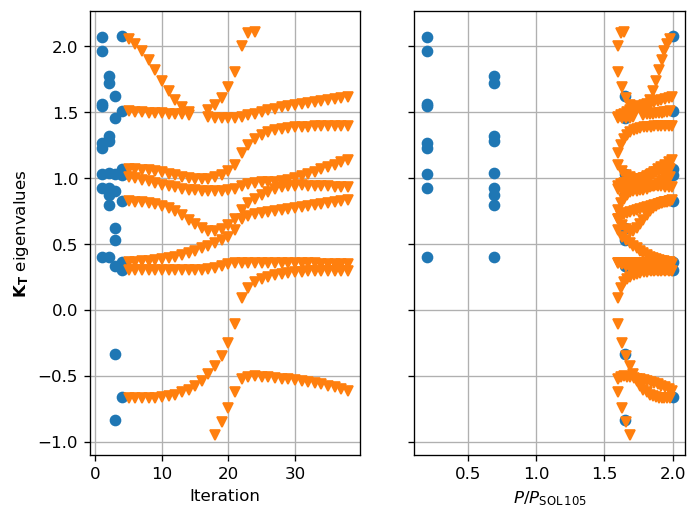

In [151]:
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Try to unload structure with Newton method to verify whether the found path is separated from the natural one.

In [67]:
# Modify second subcase
box_beam_bdf_input.nlparms[2].max_iter = 50
del box_beam_bdf_input.nlpcis[2]

# Remove subcase 3 and 4
del box_beam_bdf_input.subcases[3]
del box_beam_bdf_input.subcases[4]

In [68]:
input_filename = f'bifurcation_verification_2Psol105_epsp1e-3_{no_eigenvalues:d}eigenvalues_newton'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-3_7eigenvalues_newton.bdf completed
Wall time: 224.0 s


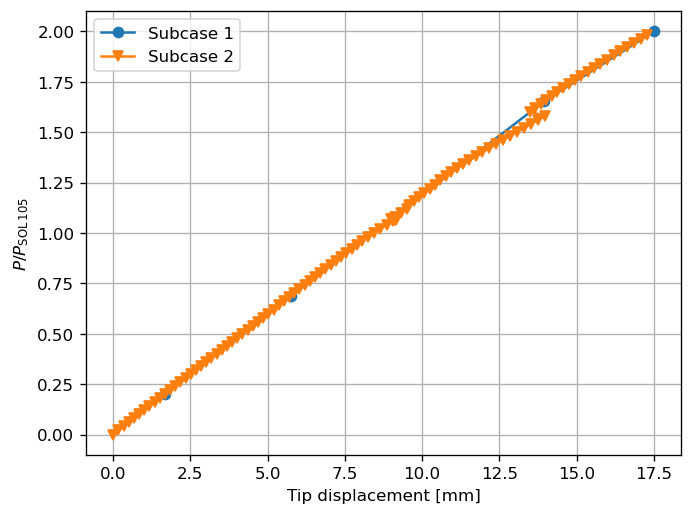

In [69]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

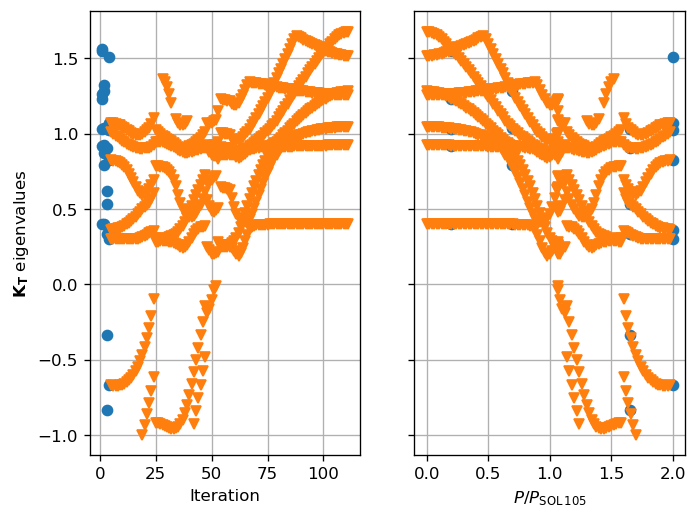

In [70]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Rerun analysis for $EPSP=10^{-1}, EPSW=10^{-1}$.

In [71]:
# Modify convergence tolerance of subcases 1 and 2
for subcase_id in range(1, 3):
    box_beam_bdf_input.nlparms[subcase_id].eps_p = 1e-1
    box_beam_bdf_input.nlparms[subcase_id].eps_w = 1e-1

# Reinstate arc-length method for second subcase
box_beam_bdf_input.add_nlpci(nlpci_id=subcase_id, Type='CRIS', minalr=1e-2, maxalr=1.01, desiter=5, mxinc=60)

NLPCI          2    CRIS     .01    1.01      0.               5      60

In [72]:
input_filename = 'bifurcation_verification_2Psol105_epsp1e-1'
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_epsp1e-1.bdf completed
Wall time: 37.0 s


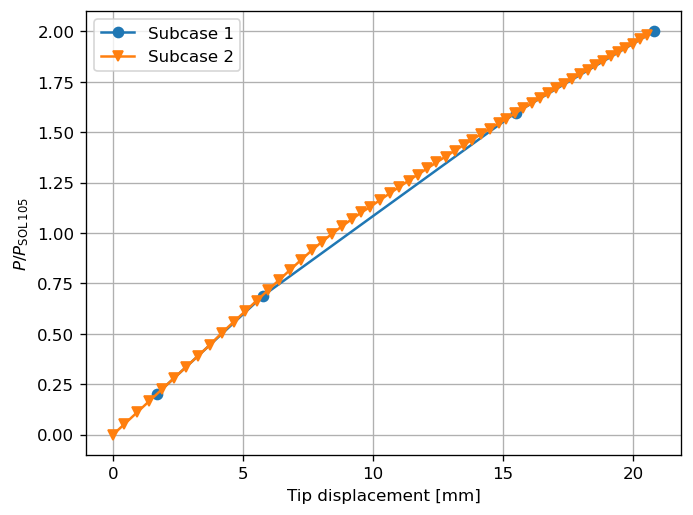

In [73]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

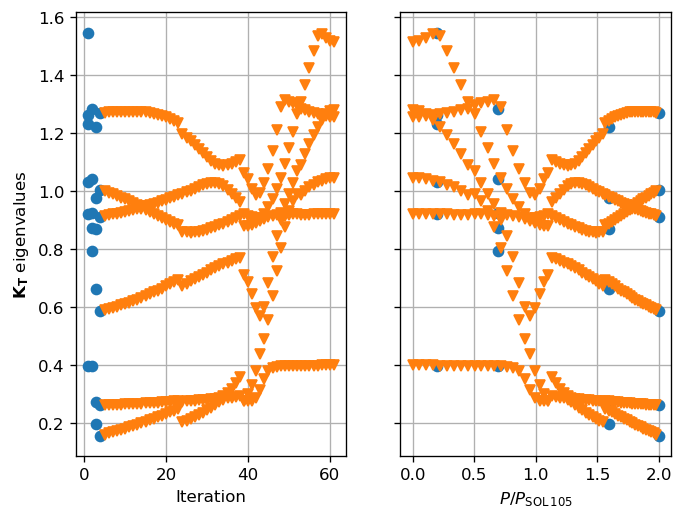

In [74]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Let's investigate possible bifurcation close to $P/P_\text{SOL 105}=1.1$.

In [75]:
load_factor = 1.3
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify applied load
box_beam_bdf_input.nlpcis[2].mxinc = 30

In [76]:
input_filename = f'bifurcation_verification_{load_factor:.1f}Psol105_epsp1e-1'.replace('.','_')
op2_output_1_3Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_3Psol105_epsp1e-1.bdf completed
Wall time: 20.0 s


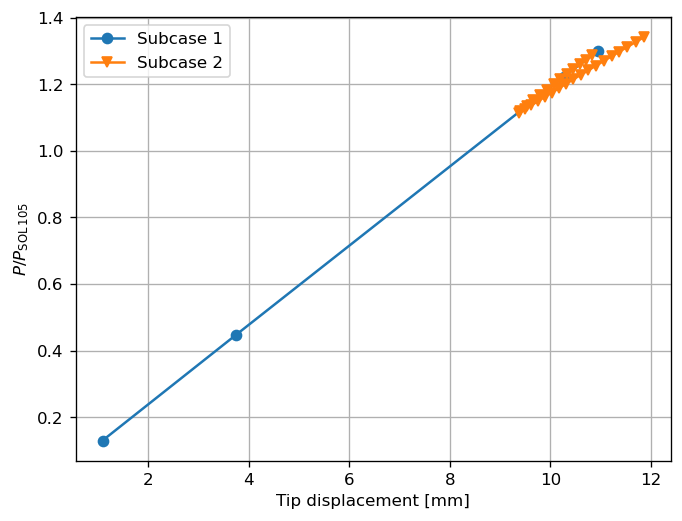

In [77]:
_, applied_loads_1_3Psol105_epsp1em1, tip_displacements_1_3Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_3Psol105_epsp1em1, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements_1_3Psol105_epsp1em1, applied_loads_1_3Psol105_epsp1em1)

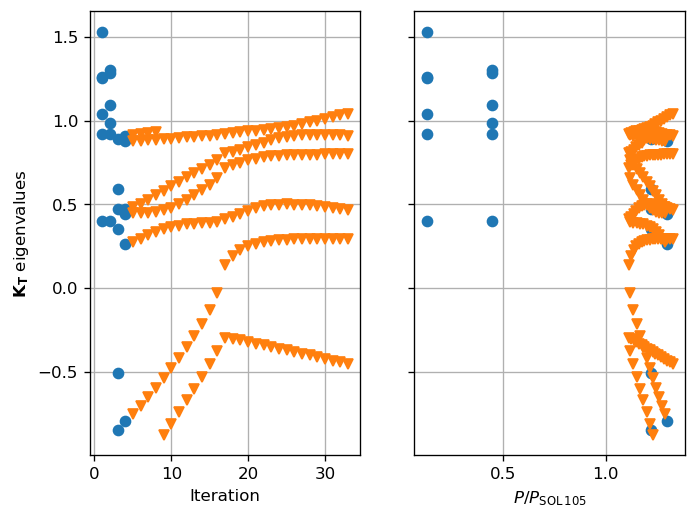

In [78]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads_1_3Psol105_epsp1em1)

Unload with Newton method.

In [79]:
# Modify second subcase
del box_beam_bdf_input.nlpcis[2]

In [80]:
input_filename = f'bifurcation_verification_{load_factor:.1f}Psol105_epsp1e-1_newton'.replace('.', '_')
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_3Psol105_epsp1e-1_newton.bdf completed
Wall time: 56.0 s


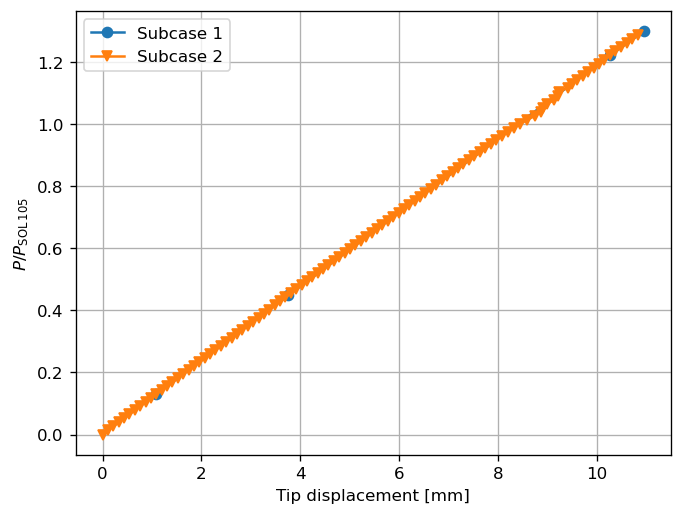

In [81]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

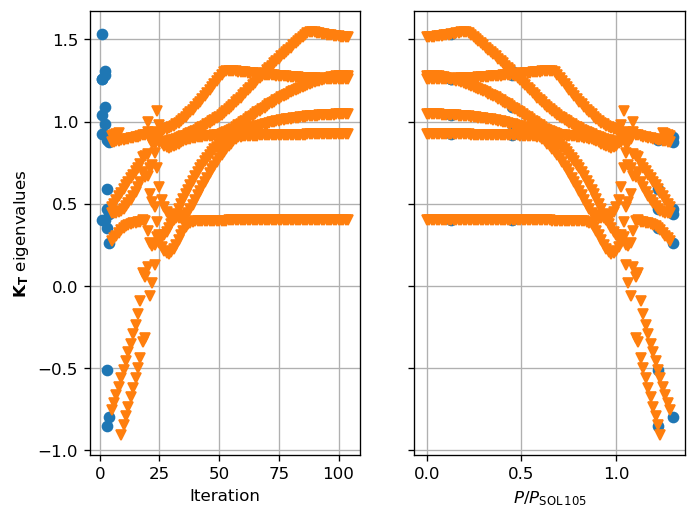

In [82]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Rerun analysis for $EPSP=10^{-3}, EPSW=10^{-7}$.

In [83]:
# Modify convergence tolerance of subcases 1 and 2
for subcase_id in range(1, 3):
    box_beam_bdf_input.nlparms[subcase_id].eps_p = 1e-3
    box_beam_bdf_input.nlparms[subcase_id].eps_w = 1e-7

# Reinstate arc-length method for second subcase
box_beam_bdf_input.add_nlpci(nlpci_id=subcase_id, Type='CRIS', minalr=1e-2, maxalr=1.01, desiter=5, mxinc=60)

NLPCI          2    CRIS     .01    1.01      0.               5      60

In [84]:
input_filename = f'bifurcation_verification_{load_factor:.1f}Psol105_epsp1e-3'.replace('.','_')
op2_output = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_1_3Psol105_epsp1e-3.bdf completed
Wall time: 46.0 s


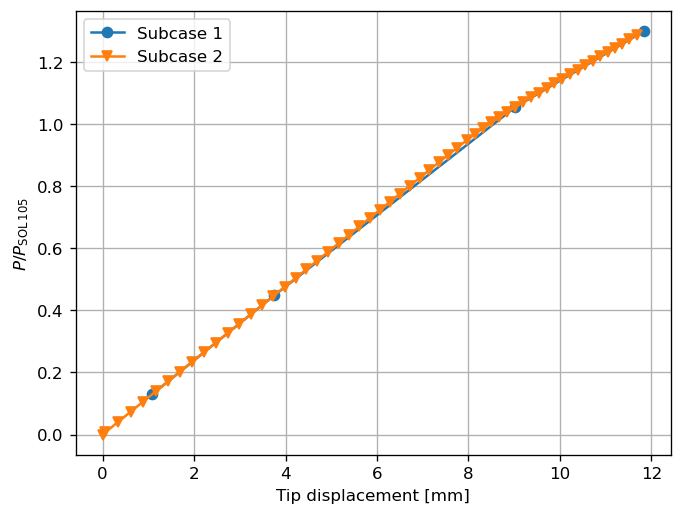

In [85]:
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
plot_load_displacement_diagram(tip_displacements, applied_loads)

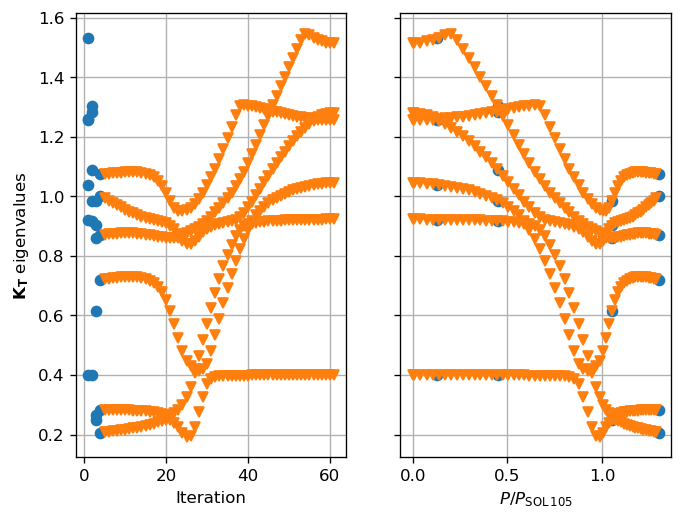

In [86]:
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_filename, applied_loads)

Use very fine nonlinear analysis parameters.

In [87]:
load_factor = 2
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify applied load
box_beam_bdf_input.case_control_deck.subcases[0].add_result_type('STRAIN', 'ALL', ['PLOT'])  # store strain data of all nodes in the op2 file

# Modify subcase 1
subcase_id = 1
box_beam_bdf_input.nlparms[subcase_id].ninc = 100
box_beam_bdf_input.nlpcis[subcase_id].minalr = 1e-2
box_beam_bdf_input.nlpcis[subcase_id].maxalr = 1.01
box_beam_bdf_input.nlpcis[subcase_id].desiter = 5
box_beam_bdf_input.nlpcis[subcase_id].mxinc = 100

# Delete subcase 2
del box_beam_bdf_input.subcases[2]

In [88]:
input_filename = 'bifurcation_verification_2Psol105_fine'
op2_output_2Psol105_fine = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf_input.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

Nastran job bifurcation_verification_2Psol105_fine.bdf completed
Wall time: 55.0 s


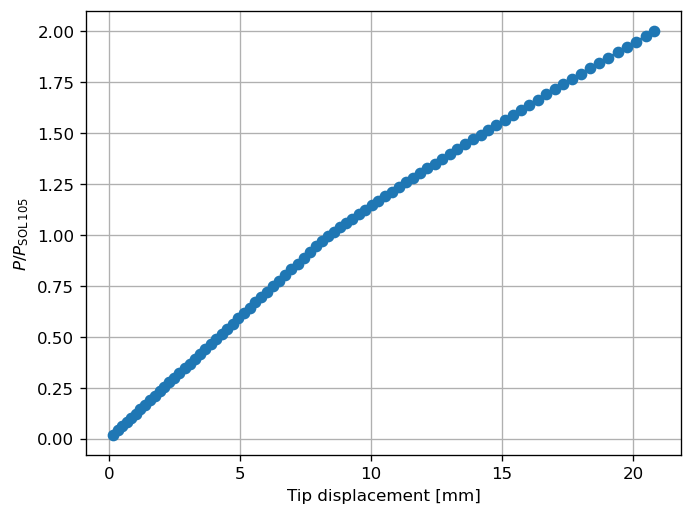

In [89]:
_, applied_loads_2Psol105_fine, tip_displacements_2Psol105_fine = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_fine, displacement_node_id=master_node_id)

_, ax = plt.subplots()
ax.plot(tip_displacements_2Psol105_fine[subcase_id][:, displacement_component_index], applied_loads_2Psol105_fine[subcase_id][:, load_component_index]/sol_105_buckling_load, marker=markers[0])
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

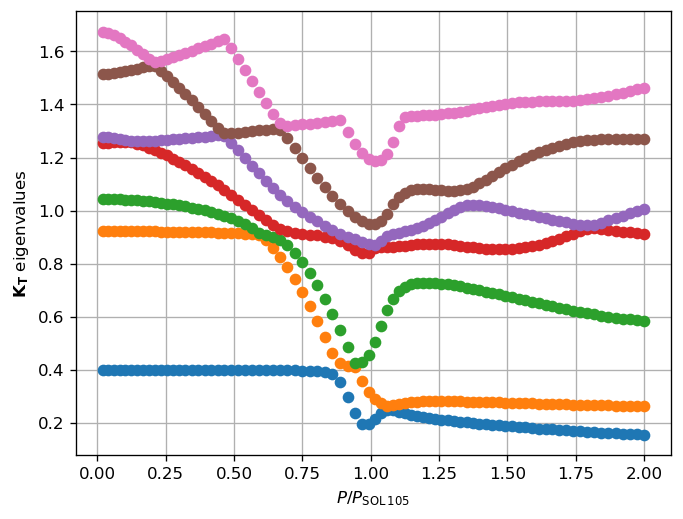

In [90]:
# Read eigenvalues of tangent stiffness matrix
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Plot lowest eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads_2Psol105_fine[subcase_id][:, displacement_component_index]/sol_105_buckling_load, eigenvalues.T, markers[0])
ax.set_xlabel('$P/P_\mathrm{SOL\/105}$')
ax.set_ylabel('$\mathbf{K_T}$ eigenvalues')
ax.grid(visible=True)
plt.show()

Let's calculate linear buckling with SOL 105 and find point of maximum displacement in the buckling shape.

In [91]:
del box_beam_bdf_input.subcases[1]  # delete subcase 1
input_filename = 'bifurcation_verification_sol_105'
op2_output = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_filename, run_flag=False)

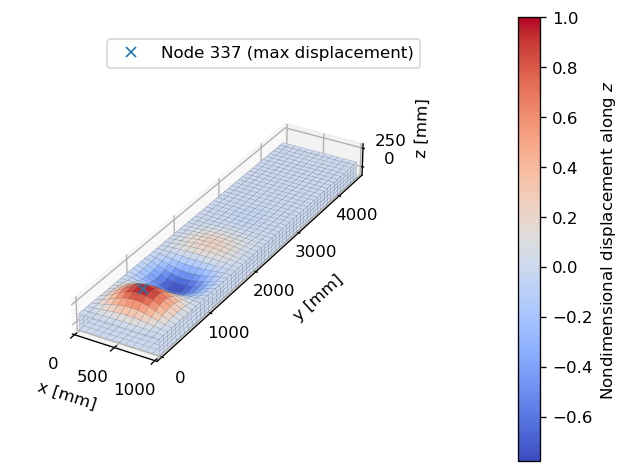

In [92]:
buckling_subcase_id = 2
max_displacement_node_id = np.argmax(op2_output.eigenvectors[buckling_subcase_id].data[0, :, 2]) + 1
_, ax = pynastran_utils.plot_buckling_mode(op2_object=op2_output, subcase_id=buckling_subcase_id, displacement_component= 'tz', colormap='coolwarm')  # plot buckling mode
max_displacement_node_xyz = op2_output.nodes[max_displacement_node_id].xyz + 200*op2_output.eigenvectors[buckling_subcase_id].data[0, max_displacement_node_id - 1, 0:3]
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x', label=f'Node {max_displacement_node_id:d} (max displacement)', zorder=4)
ax.legend()

# We define a function to adjust axes ticks and labels' position, that we will use also later
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Set axes ticks and labels' position and show plot
set_ticks_and_labels_position(ax)
plt.show()

In [93]:
_, _, panel_displacements_2Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_epsp1em3, displacement_node_id=max_displacement_node_id)
_, _, panel_displacements_1_3Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_1_3Psol105_epsp1em1, displacement_node_id=max_displacement_node_id)
_, _, panel_displacements_2Psol105_fine = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output_2Psol105_fine, displacement_node_id=max_displacement_node_id)

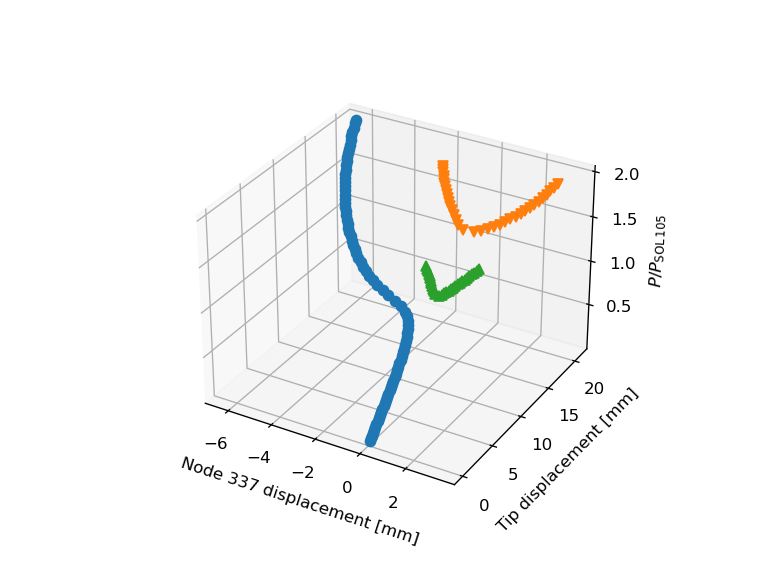

In [94]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')
# Plot load applied along x vs rotation of pin-supported node vs applied along y
ax_3d.plot3D(panel_displacements_2Psol105_fine[1][:, displacement_component_index], tip_displacements_2Psol105_fine[1][:, displacement_component_index], applied_loads_2Psol105_fine[1][:, load_component_index]/sol_105_buckling_load, markers[0], color=colors[0])  # sign of load along x is inverted to show a positive load in the plot
ax_3d.plot3D(panel_displacements_2Psol105_epsp1em3[2][:, displacement_component_index], tip_displacements_2Psol105_epsp1em3[2][:, displacement_component_index], applied_loads_2Psol105_epsp1em3[2][:, load_component_index]/sol_105_buckling_load, markers[1], color=colors[1])
ax_3d.plot3D(panel_displacements_1_3Psol105_epsp1em1[2][:, displacement_component_index], tip_displacements_1_3Psol105_epsp1em1[2][:, displacement_component_index], applied_loads_1_3Psol105_epsp1em1[2][:, load_component_index]/sol_105_buckling_load, markers[2], color=colors[2])
# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

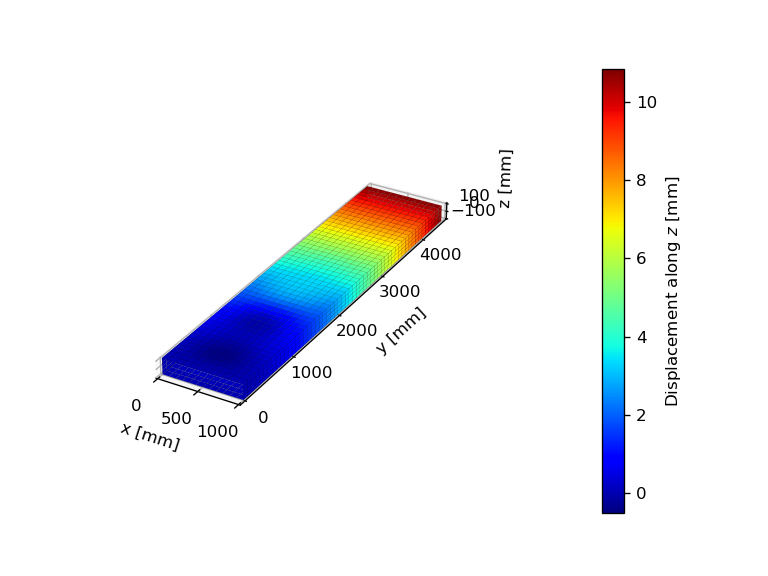

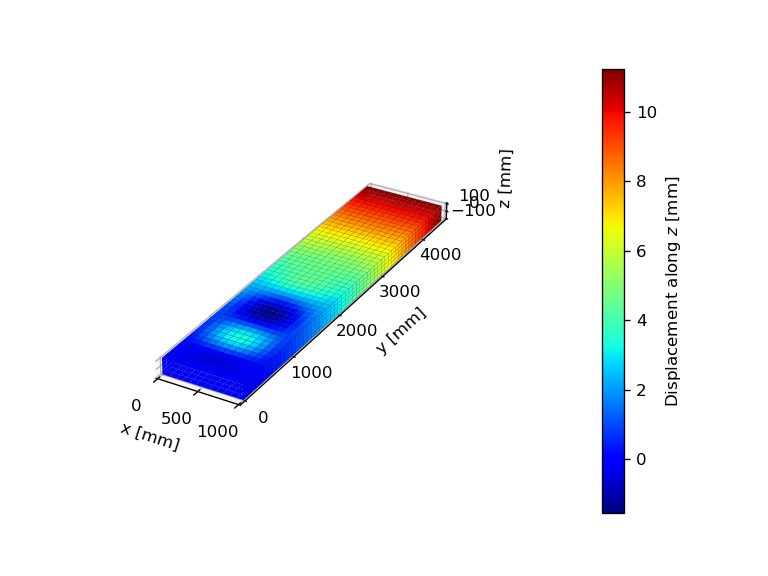

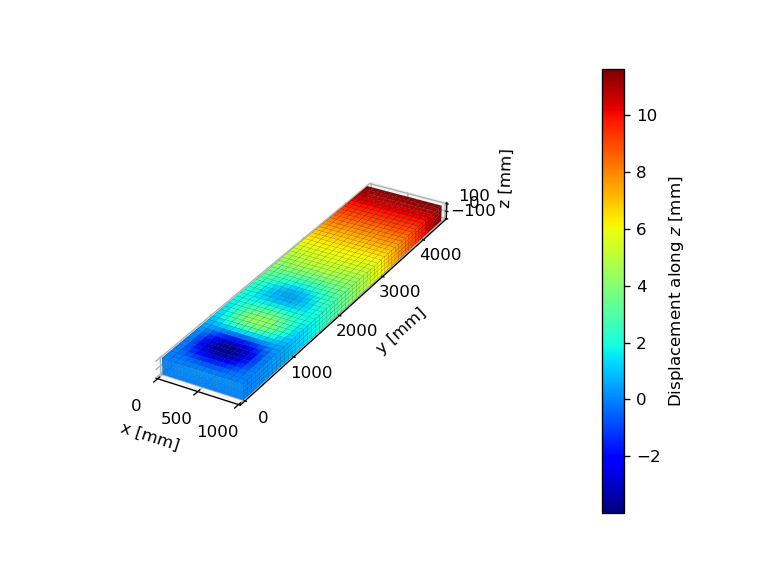

In [95]:
# Plot static deformation for first point of first separated path
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_1_3Psol105_epsp1em1, subcase_id=2, load_step=1, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot static deformation for point corresponding to closest applied load on same path
load_step = np.argmin(np.abs(applied_loads_1_3Psol105_epsp1em1[2][1:, 2] - applied_loads_1_3Psol105_epsp1em1[2][0, 2])) + 2
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_1_3Psol105_epsp1em1, subcase_id=2, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot static deformation for point corresponding to closest applied load on natural path
load_step = np.argmin(np.abs(applied_loads_2Psol105_fine[1][:, 2] - applied_loads_1_3Psol105_epsp1em1[2][0, 2])) + 1
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_2Psol105_fine, subcase_id=1, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

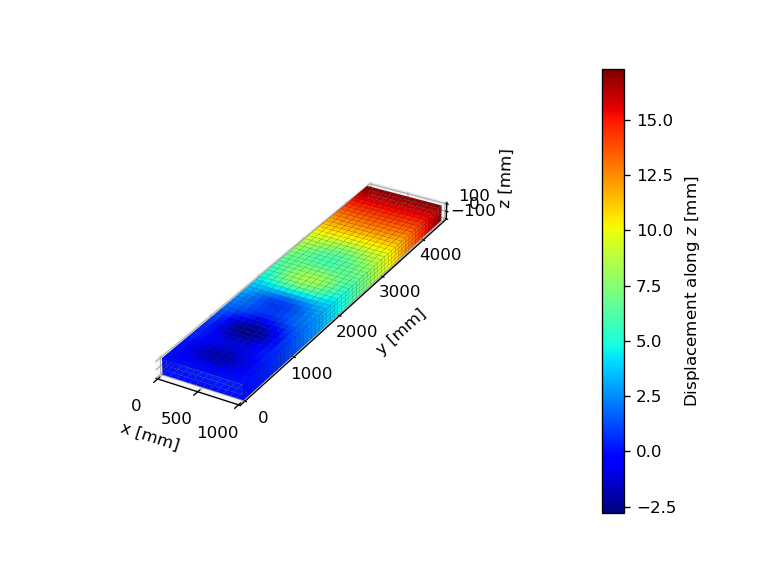

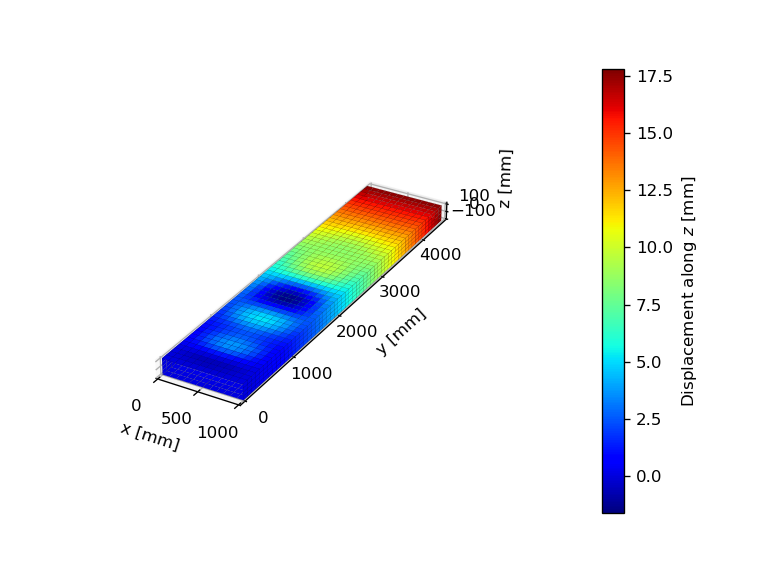

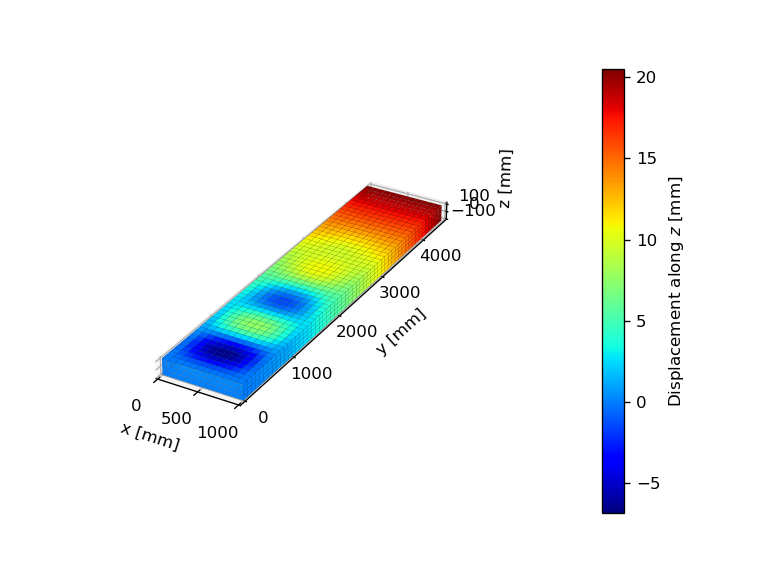

In [96]:
# Plot static deformation for first point of second separated path
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_2Psol105_epsp1em3, subcase_id=2, load_step=1, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot static deformation for point corresponding to closest applied load on same path
load_step = np.argmin(np.abs(applied_loads_2Psol105_epsp1em3[2][1:, 2] - applied_loads_2Psol105_epsp1em3[2][0, 2])) + 2
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_2Psol105_epsp1em3, subcase_id=2, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot static deformation for point corresponding to closest applied load on natural path
load_step = np.argmin(np.abs(applied_loads_2Psol105_fine[1][:, 2] - applied_loads_2Psol105_epsp1em3[2][0, 2])) + 1
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output_2Psol105_fine, subcase_id=1, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()